In [4]:
#importing my libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score


#dataset

df = pd.read_csv("/spotify_history.csv")
df.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [5]:
#prepping data
df.info()
df.isnull().sum()

#defining out target variables
df["early_skip"] = (df["ms_played"]< 30000).astype(int)
df["early_skip"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149860 entries, 0 to 149859
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   spotify_track_uri  149860 non-null  object
 1   ts                 149860 non-null  object
 2   platform           149860 non-null  object
 3   ms_played          149860 non-null  int64 
 4   track_name         149860 non-null  object
 5   artist_name        149860 non-null  object
 6   album_name         149860 non-null  object
 7   reason_start       149717 non-null  object
 8   reason_end         149743 non-null  object
 9   shuffle            149860 non-null  bool  
 10  skipped            149860 non-null  bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 10.6+ MB


,count
early_skip,
0,94200
1,55660


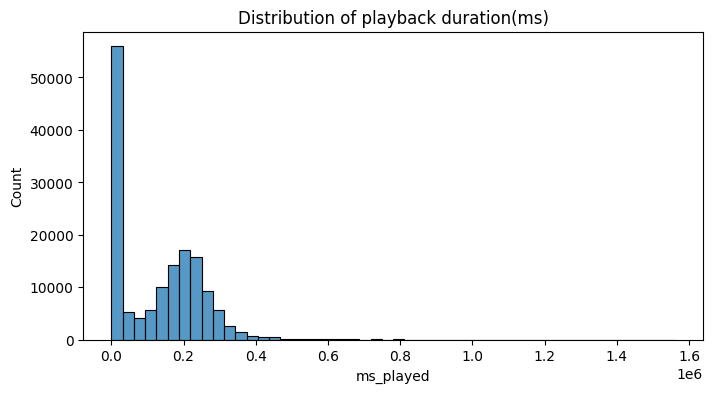

In [6]:
# EDA - skip behavior
# playbk duration dis

plt.figure(figsize=(8,4))
sns.histplot(df["ms_played"], bins=50)
plt.title("Distribution of playback duration(ms)")
plt.show()





In [7]:
#skip rate by start reason & platform based
df.groupby("reason_start")["early_skip"].mean().sort_values()
df.groupby("platform")["early_skip"].mean()

,early_skip
platform,
android,0.385357
cast to device,0.130580
iOS,0.214497
mac,0.043367
web player,0.360000
windows,0.286221


In [8]:
#features


df["ts"] = pd.to_datetime(df["ts"])
df["hour"] = df["ts"].dt.hour

# cyclical version (for models later)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

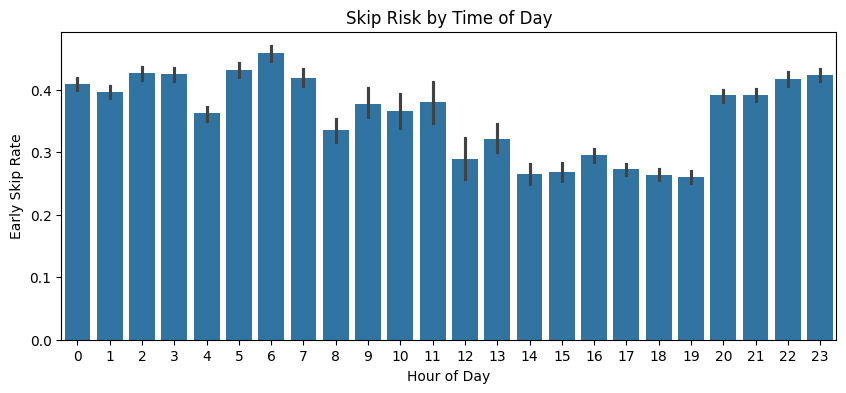

In [9]:
plt.figure(figsize=(10,4))
sns.barplot(x="hour", y="early_skip", data=df)
plt.title("Skip Risk by Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Early Skip Rate")
plt.show()


In [22]:
#modelling
features = [
    "shuffle",
    "platform",
    "reason_start",
    "hour_sin",
    "hour_cos"
]

#encode
X = df[features]
y = df["early_skip"]
X = pd.get_dummies(X, drop_first=True)



In [23]:
#training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#logistic reg
model=LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#randomforest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [24]:
#evaluation and confusion matrix

#logistic
print("logistic regression report")
print(classification_report(y_test, y_pred))
#randomforest
print("Random Forest Classification Report")
print(classification_report(y_test, rf_pred))





logistic regression report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     18831
           1       0.77      0.77      0.77     11141

    accuracy                           0.83     29972
   macro avg       0.82      0.82      0.82     29972
weighted avg       0.83      0.83      0.83     29972

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     18831
           1       0.78      0.78      0.78     11141

    accuracy                           0.83     29972
   macro avg       0.82      0.82      0.82     29972
weighted avg       0.83      0.83      0.83     29972



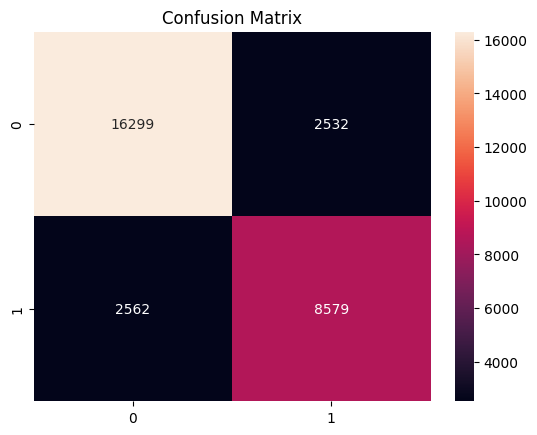

In [25]:
#confusion matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d"
)
plt.title("Confusion Matrix")
plt.show()

In [26]:
#for model comparison

comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, y_pred),
                 accuracy_score(y_test, rf_pred)
    ],
    "Recall (Early Skip)":[
        recall_score(y_test, y_pred),
        recall_score(y_test, rf_pred)
    ]
})

comparison


,Model,Accuracy,Recall (Early Skip)
0,Logistic Regression,0.830041,0.770039
1,Random Forest,0.834746,0.779553


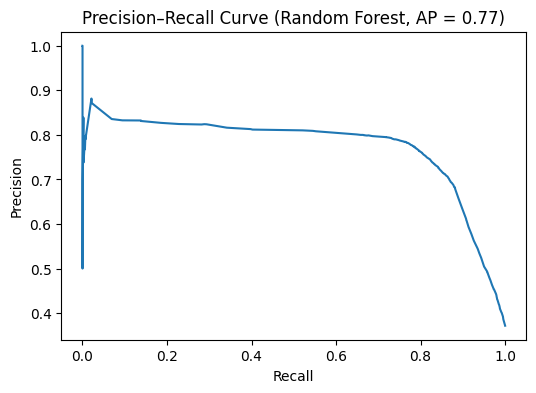

In [28]:
#precision-recall curve analysis for rf


# get probability of early skip (class = 1)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

precision, recall, _=precision_recall_curve(y_test, rf_probs)
ap =average_precision_score(y_test, rf_probs)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Random Forest, AP = {ap:.2f})")
plt.show()


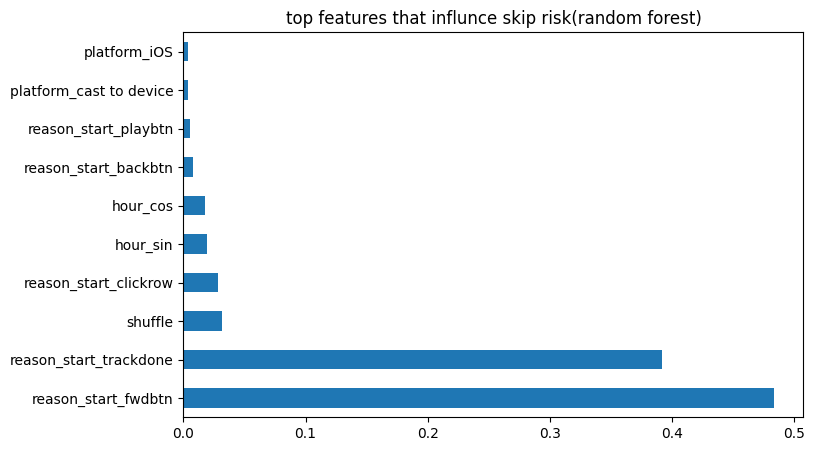

In [29]:
#random forest feature importance

importances = pd.Series(
    rf_model.feature_importances_,
    index= X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.head(10).plot(kind="barh")
plt.title("top features that influnce skip risk(random forest)")
plt.show()

In [30]:
#Prediction and Skip-Risk Segmentation
# Predict skip probability using Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]

original_results = df.loc[X_test.index, [
    "shuffle",
    "hour",
    "platform",
    "reason_start"
]].copy()

original_results["true_label"] = y_test.values
original_results["predicted_skip_risk"] = rf_probs

original_results["risk_bucket"] = pd.cut(
    original_results["predicted_skip_risk"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)

original_results.head()



,shuffle,hour,platform,reason_start,true_label,predicted_skip_risk,risk_bucket
64428,False,5,android,fwdbtn,0,0.397270,Medium
98738,True,15,android,fwdbtn,0,0.740648,High
43276,True,4,android,fwdbtn,1,0.757945,High
68325,False,3,cast to device,trackdone,0,0.000000,NaN
144246,True,21,android,fwdbtn,0,0.803880,High


In [31]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!ls /content


drive  sample_data


In [ ]:
!git clone https://github.com/adiitea-io/spotify-skip-analysis-.git
